# Praca domowa 6
## Karol Degórski

## Analiza zbioru danych *Olivetti Faces*

## Import potrzebnych pakietów

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns

## Wczytanie danych *Olivetti Faces*

In [2]:
from sklearn.datasets import fetch_olivetti_faces

In [3]:
faces = fetch_olivetti_faces()

In [4]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [5]:
faces.data.shape

(400, 4096)

Widzimy że w zbiorze mamy 400 obrazków w formacie 64x64 pikseli

## Przykładowe obrazy

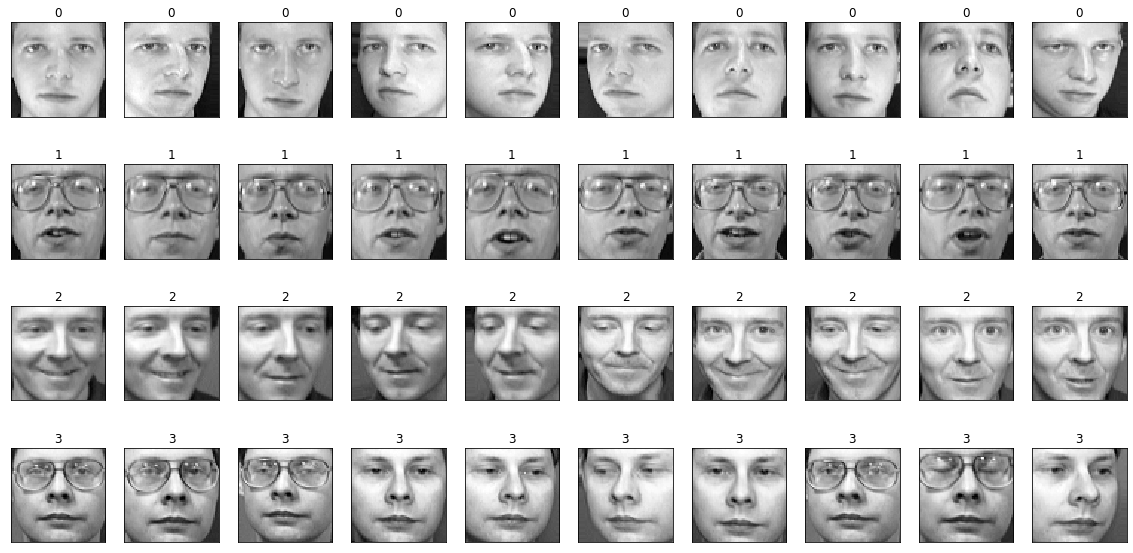

In [6]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(faces.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Z dokumentacji zbioru możemy się dowiedzieć, że zbiór ten zawiera po 10 różnych zdjęć dla 40 osób. Powyżej widzimy zdjęcia dla 4 pierwszych osób

## Kompresja zbioru danych algorytmem PCA

In [7]:
X, y = faces.data, faces.target

In [8]:
from sklearn.decomposition import PCA

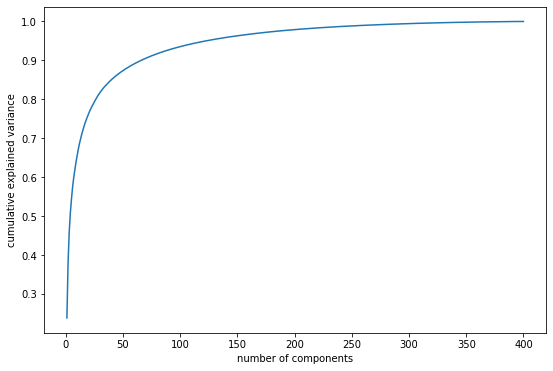

In [9]:
pca = PCA().fit(X)

plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [10]:
np.cumsum(pca.explained_variance_ratio_)[25]

0.7988096

In [11]:
np.cumsum(pca.explained_variance_ratio_)[64]

0.89883924

In [12]:
np.cumsum(pca.explained_variance_ratio_)[144]

0.9611293

Widzimy, że dla np. 25 (5x5 pikseli) składowych mamy wyjaśnione około 80% wariancji, za to dla 64 składowych (8x8 pikseli) jest to już prawie 90%. Dla 144 (12x12 pikseli) składowych jest to już około 96%. Wykorzystamy te znalezione liczby komponentów do kompresji danych i obliczymy stopień kompresji

In [13]:
pca_25 = PCA(25)
pca_64 = PCA(64)
pca_144 = PCA(144)

In [14]:
pca_25.fit(X)
pca_64.fit(X)
pca_144.fit(X)

PCA(n_components=144)

In [15]:
X_25 = pca_25.transform(X)
X_64 = pca_64.transform(X)
X_144 = pca_144.transform(X)

In [16]:
print(X_25.shape)
print(X_64.shape)
print(X_144.shape)

(400, 25)
(400, 64)
(400, 144)


Widzimy, że kompresja danych udała się

Obliczymy zatem stopnie rekonstrukcji danych

In [17]:
CR_25 = faces.data.shape[1] / X_25.shape[1]
CR_64 = faces.data.shape[1] / X_64.shape[1]
CR_144 = faces.data.shape[1] / X_144.shape[1]

print("CR_25 =", np.round(CR_25, 2))
print("CR_64 =", np.round(CR_64, 2))
print("CR_144 =", np.round(CR_144, 2))

CR_25 = 163.84
CR_64 = 64.0
CR_144 = 28.44


Jak mogliśmy się spodziewać, im mniejszy procent wariancji jest wyjaśnainy, tym uzyskujemy większy stopień kompresji danych. Dlatego też zawsze należy podjąć decyzję, czy w jakim stopniu możemy skompresować nasze dane, aby po przeprowadzeniu transformacji odwrotnej jakość była dalej zadowalajaca. Zatem teraz przeprowadźmy transformację odwrotną

## Transformacja odwrotna skompresowanych danych

In [18]:
X_inv_25 = pca_25.inverse_transform(X_25)
X_25_re = np.reshape(X_inv_25,(400,64,64))

X_inv_64 = pca_64.inverse_transform(X_64)
X_64_re = np.reshape(X_inv_64,(400,64,64))

X_inv_144 = pca_144.inverse_transform(X_144)
X_144_re = np.reshape(X_inv_144,(400,64,64))

Dla około 80% wariancji:

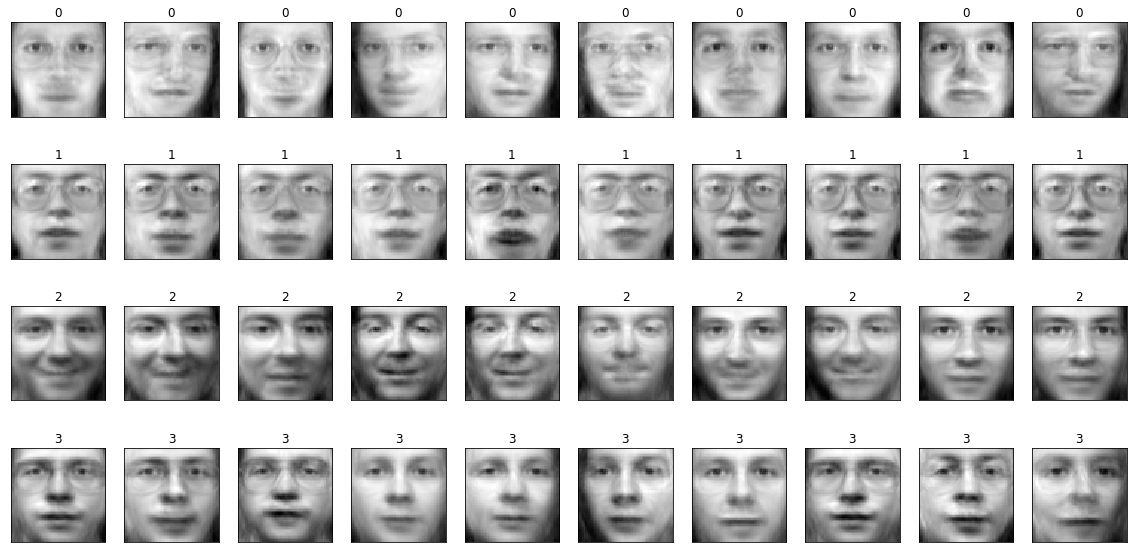

In [19]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(X_25_re[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Dla około 90% wariancji:

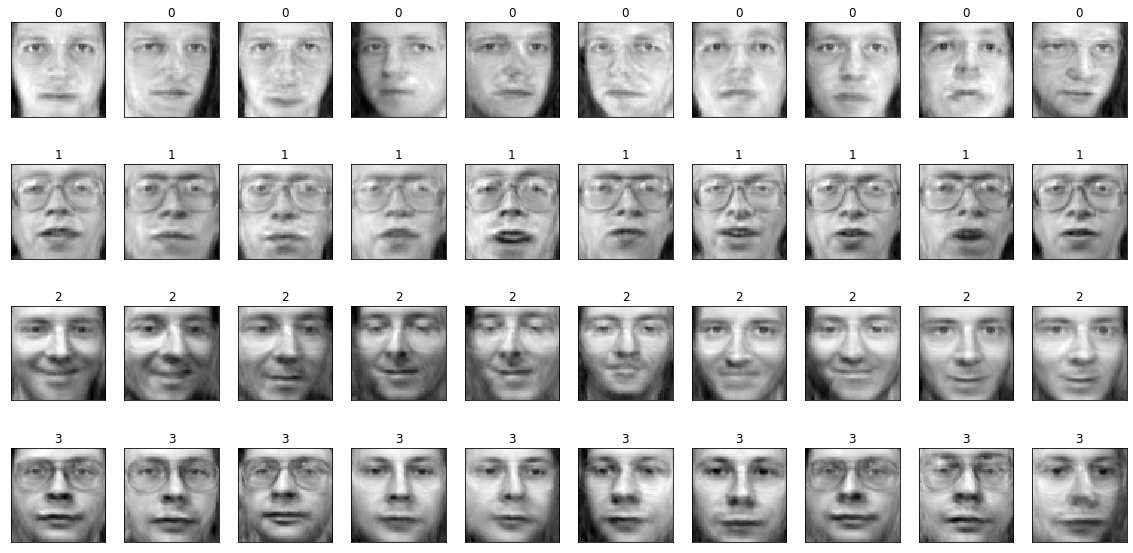

In [20]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(X_64_re[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Dla około 96% wariancji:

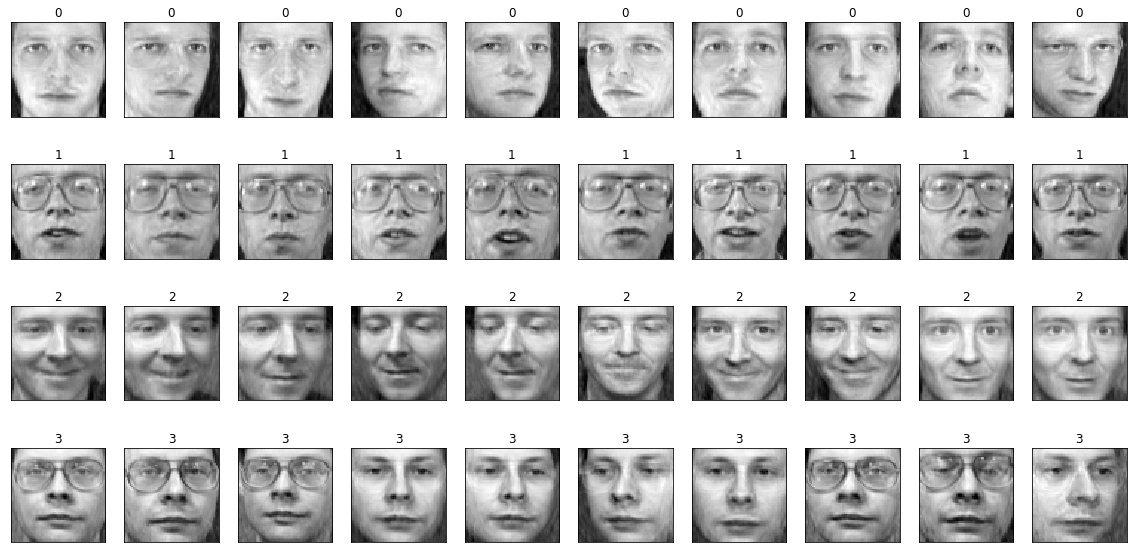

In [21]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(X_144_re[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Jak zaueażyliśmy wcześniej, im mniej wariancji wyjaśniamy, tym przeprowadzamy większą kompresję danych i przez to zdjęcia robią się mniej wyraźne. Jednak już w przypadku wyjaśniania 96% jakość jest zadowalająca, za to przy wyjaśnianiu 95% zdjęcia są już bardzo podobne do tych orginalnych

Obliczymy błąd rekonstrukcji w postaci błędu RMSE dla każdego z obrazów i zagregowany dla wszystkich

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
mean_squared_error(X, X_inv_25, squared=False)

0.061223045

In [24]:
mean_squared_error(X, X_inv_64, squared=False)

0.043134786

In [25]:
mean_squared_error(X, X_inv_144, squared=False)

0.026832275

Widzimy zatem, że błędy zagregowane dla wsyzstkich obrazów są niewielkie. Dla przypadku gdy wyjaśniamy 96% wariancji jest to już bardzo mało znaczący błąd

Zoabczymy, jak wyglądają błędy dla poszczególnych obrazów

In [26]:
rmse_25 = []
rmse_64 = []
rmse_144 = []
for i in range(400):
    rmse_25.append(mean_squared_error(X[i], X_inv_25[i], squared=False))
    rmse_64.append(mean_squared_error(X[i], X_inv_64[i], squared=False))
    rmse_144.append(mean_squared_error(X[i], X_inv_144[i], squared=False))
    

In [27]:
print("max dla 80% wariancji:", round(max(rmse_25), 6))
print("max dla 90% wariancji:", round(max(rmse_64), 6))
print("max dla 96% wariancji:", round(max(rmse_144), 6))

max dla 80% wariancji: 0.094247
max dla 90% wariancji: 0.065533
max dla 96% wariancji: 0.034038


Widzimy, że maksymalne wartości błędów też są niewielkie, zatem nie ma jakiś znaczących rozbieżności pomiędzy kompresją poszczególnych obrazów

## Modyfikowanie obrazów

**Obrócimy kilka obrazów o 90 stopni**

In [28]:
rotated = [0, 23, 78, 126, 200]

In [29]:
faces.images[0] = np.transpose(faces.images[0])
faces.data[0] = np.ravel(faces.images[0])

faces.images[23] = np.transpose(faces.images[23])
faces.data[23] = np.ravel(faces.images[23])

faces.images[78] = np.transpose(faces.images[78])
faces.data[78] = np.ravel(faces.images[78])

faces.images[126] = np.transpose(faces.images[126])
faces.data[126] = np.ravel(faces.images[126])

faces.images[200] = np.transpose(faces.images[200])
faces.data[200] = np.ravel(faces.images[200])


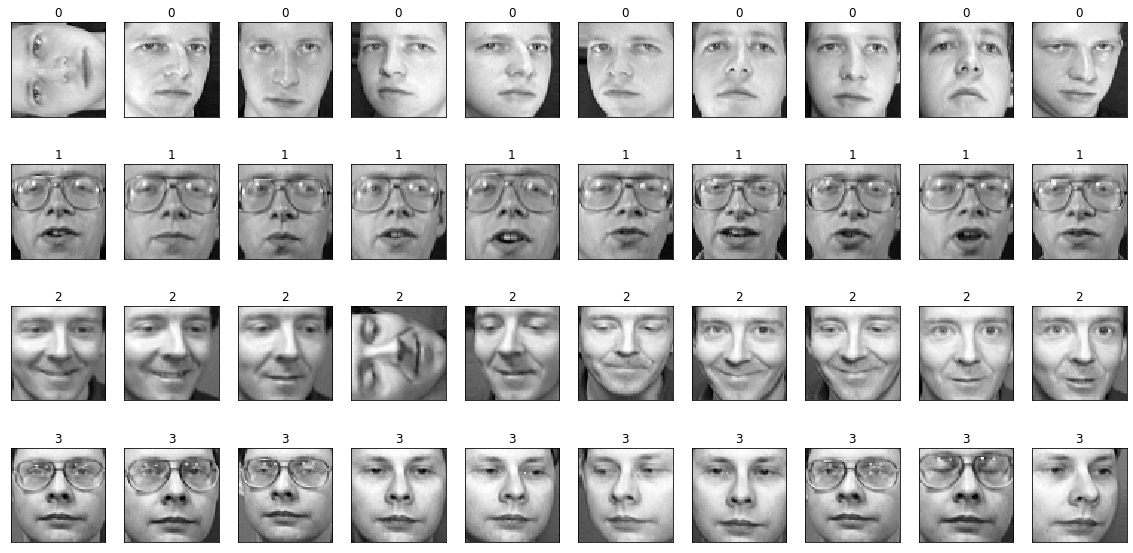

In [30]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(faces.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Jak widzimy obracanie obrazów działa poprawnie

**Przyciemnimy i pojaśnimy kilka obrazów**

In [31]:
darken_lighten = [6, 128, 28, 301]

In [32]:
faces.images[6] = faces.images[6] - np.array(0.2)
faces.images[6][faces.images[6]<0] = 0
faces.data[6] = np.ravel(faces.images[6])

faces.images[128] = faces.images[128] - np.array(0.25)
faces.images[128][faces.images[128]<0] = 0
faces.data[128] = np.ravel(faces.images[128])

faces.images[28] = faces.images[28] + np.array(0.2)
faces.images[28][faces.images[28]>1] = 1
faces.data[28] = np.ravel(faces.images[28])


faces.images[301] = faces.images[301] - np.array(0.3)
faces.images[301][faces.images[301]>1] = 1
faces.data[301] = np.ravel(faces.images[301])

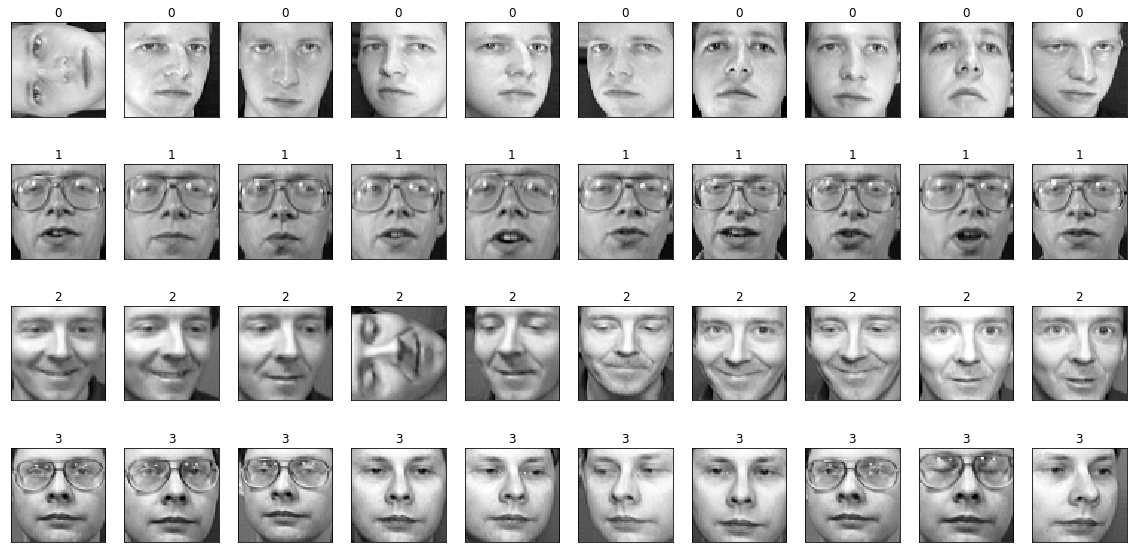

In [33]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(faces.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Na przykładzie widzimy, że pociemnianie i pojaśnianie działa

**Odbijemy kilka obrazów w poziomie**

In [34]:
horizontal = [4, 56, 34, 222]

In [35]:
faces.images[4] = faces.images[4][::-1]
faces.data[4] = np.ravel(faces.images[4])

faces.images[56] = faces.images[56][::-1]
faces.data[56] = np.ravel(faces.images[56])

faces.images[34] = faces.images[34][::-1]
faces.data[34] = np.ravel(faces.images[34])

faces.images[222] = faces.images[222][::-1]
faces.data[222] = np.ravel(faces.images[222])


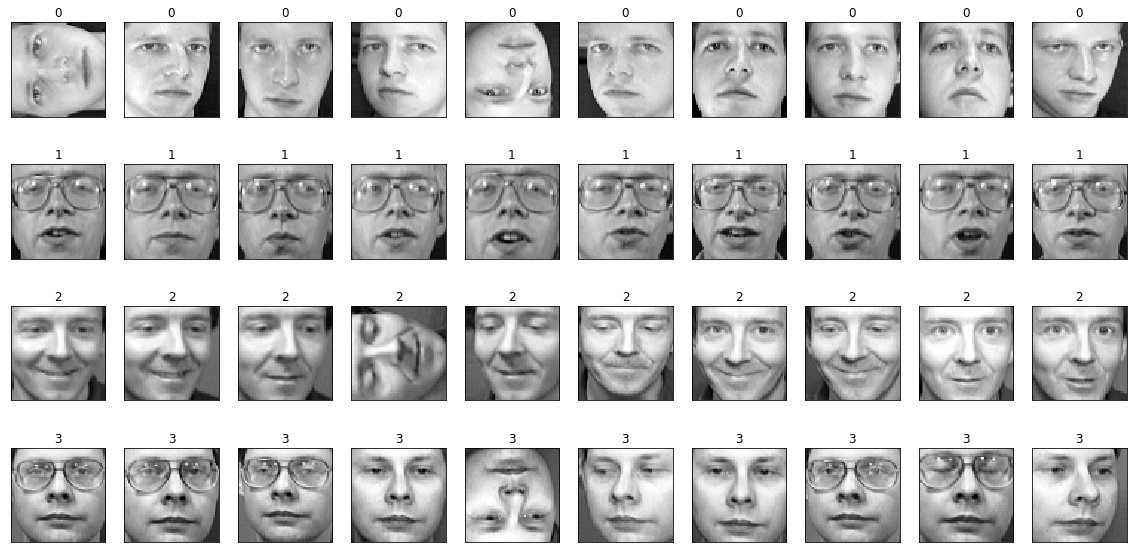

In [36]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(faces.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Możemy zobaczyć, że odbicie w poziomie zadziałało

## Transformacja i transformacja odwrotna zmodyfikowanych obrazów

In [37]:
X, y = faces.data, faces.target

In [38]:
X_mod_25 = pca_25.transform(X)
X_mod_64 = pca_64.transform(X)
X_mod_144 = pca_144.transform(X)

In [39]:
print(X_mod_25.shape)
print(X_mod_64.shape)
print(X_mod_144.shape)

(400, 25)
(400, 64)
(400, 144)


In [40]:
X_mod_inv_25 = pca_25.inverse_transform(X_mod_25)
X_mod_25_re = np.reshape(X_mod_inv_25,(400,64,64))

X_mod_inv_64 = pca_64.inverse_transform(X_mod_64)
X_mod_64_re = np.reshape(X_mod_inv_64,(400,64,64))

X_mod_inv_144 = pca_144.inverse_transform(X_mod_144)
X_mod_144_re = np.reshape(X_mod_inv_144,(400,64,64))

Dla około 80% wariancji:

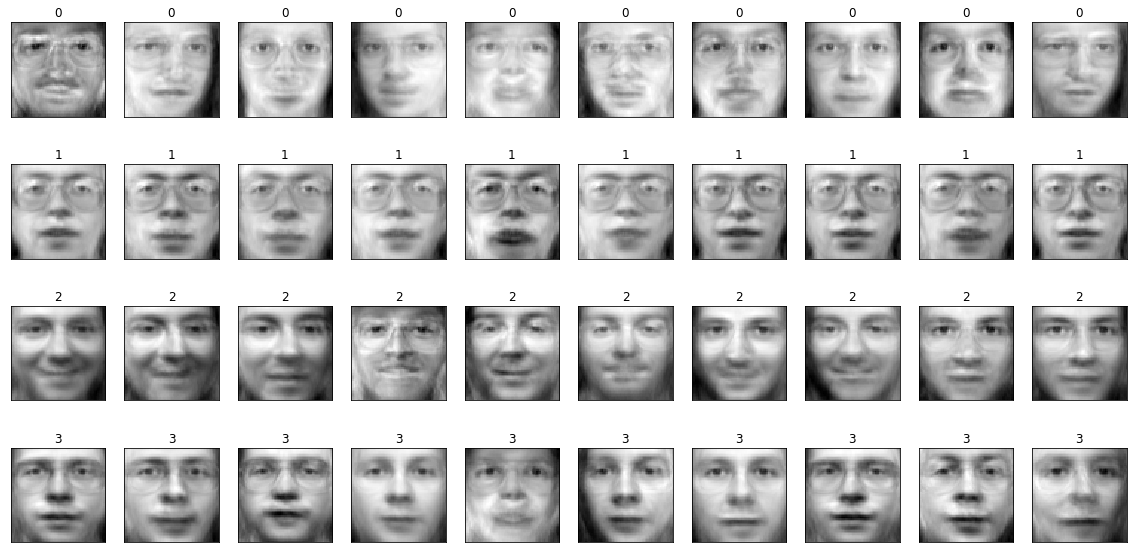

In [41]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(X_mod_25_re[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Dla około 90% wariancji:

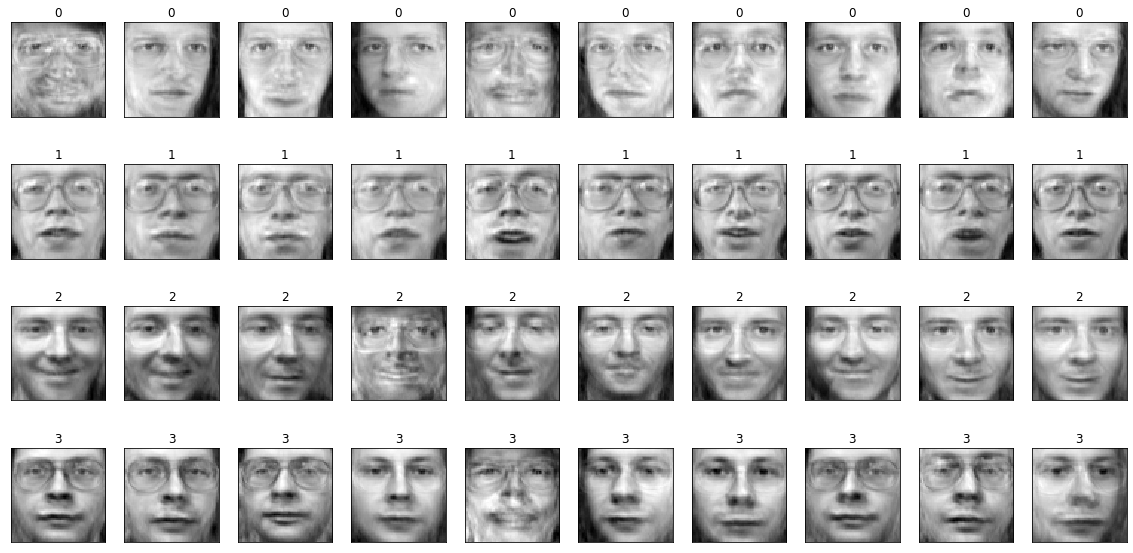

In [42]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(X_mod_64_re[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Dla około 96% wariancji:

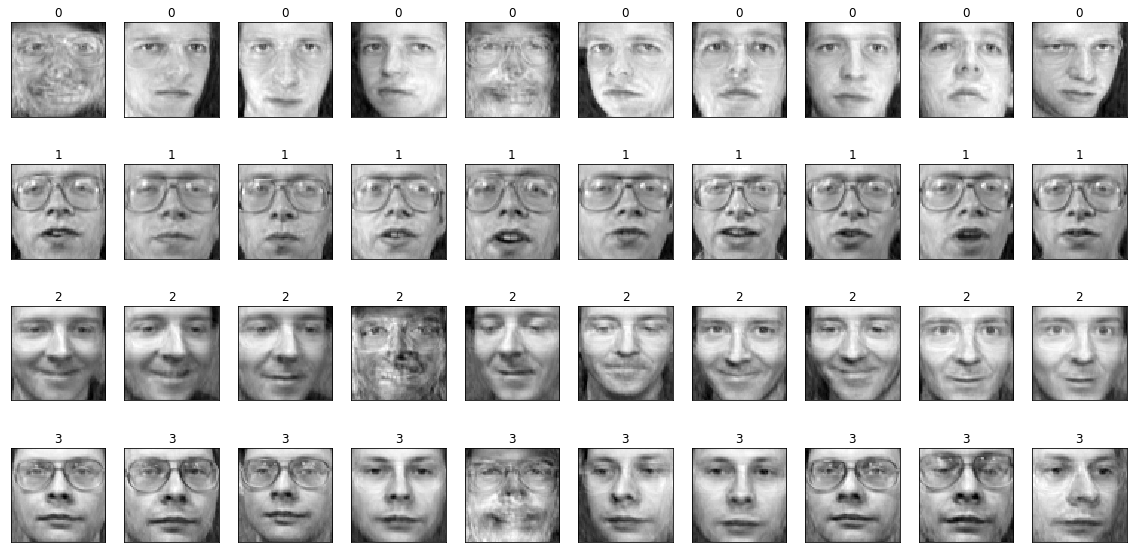

In [43]:
nrows, ncols = 4, 10
plt.figure(figsize=(20,10))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(X_mod_144_re[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(faces.target[i])
plt.show()

Modyfikacja obrazów pogorszyła wyniki

Ponownie obliczymy błąd rekonstrukcji w postaci błędu RMSE dla każdego z obrazów i zagregowany dla wszystkich

In [44]:
mean_squared_error(X, X_mod_inv_25, squared=False)

0.06338647

In [45]:
mean_squared_error(X, X_mod_inv_64, squared=False)

0.04532135

In [46]:
mean_squared_error(X, X_mod_inv_144, squared=False)

0.029468248

Widzimy zatem, że błędy zagregowane dla wszystkich obrazów zwiększyły się w stosunku do sytuacji gdy nie modyfikowaliśmy obrazów.

Zoabczymy, jak wyglądają błędy dla poszczególnych obrazów

In [47]:
rmse_mod_25 = []
rmse_mod_64 = []
rmse_mod_144 = []
for i in range(400):
    rmse_mod_25.append(mean_squared_error(X[i], X_mod_inv_25[i], squared=False))
    rmse_mod_64.append(mean_squared_error(X[i], X_mod_inv_64[i], squared=False))
    rmse_mod_144.append(mean_squared_error(X[i], X_mod_inv_144[i], squared=False))
    

In [48]:
print("max dla 80% wariancji:", round(max(rmse_mod_25), 6))
print("max dla 90% wariancji:", round(max(rmse_mod_64), 6))
print("max dla 96% wariancji:", round(max(rmse_mod_144), 6))

max dla 80% wariancji: 0.154026
max dla 90% wariancji: 0.117128
max dla 96% wariancji: 0.099289


Widzimy, że maksymalne wartości błędu znacząco wzrosły w stosunku do sytuacji bez modyfikacji

Policzymy jeszcze błąd rekonstrukcji dla każdego typu modyfikacji

Dla obrotu o 90 stopni:

In [49]:
rmse_rotated_25 = []
rmse_rotated_64 = []
rmse_rotated_144 = []
for i in rotated:
    rmse_rotated_25.append(rmse_mod_25[i])
    rmse_rotated_64.append(rmse_mod_64[i])
    rmse_rotated_144.append(rmse_mod_144[i])
rmse_rotated_25 = sum(rmse_rotated_25) / len(rmse_rotated_25)
rmse_rotated_64 = sum(rmse_rotated_64) / len(rmse_rotated_64)
rmse_rotated_144 = sum(rmse_rotated_144) / len(rmse_rotated_144)

In [50]:
print("max dla 80% wariancji:", round(rmse_rotated_25, 6))
print("max dla 90% wariancji:", round(rmse_rotated_64, 6))
print("max dla 96% wariancji:", round(rmse_rotated_144, 6))

max dla 80% wariancji: 0.123693
max dla 90% wariancji: 0.101332
max dla 96% wariancji: 0.08675


Dla przyciemneinia/pojaśnienia

In [51]:
rmse_darken_lighten_25 = []
rmse_darken_lighten_64 = []
rmse_darken_lighten_144 = []
for i in darken_lighten:
    rmse_darken_lighten_25.append(rmse_mod_25[i])
    rmse_darken_lighten_64.append(rmse_mod_64[i])
    rmse_darken_lighten_144.append(rmse_mod_144[i])
rmse_darken_lighten_25 = sum(rmse_darken_lighten_25) / len(rmse_darken_lighten_25)
rmse_darken_lighten_64 = sum(rmse_darken_lighten_64) / len(rmse_darken_lighten_64)
rmse_darken_lighten_144 = sum(rmse_darken_lighten_144) / len(rmse_darken_lighten_144)

In [52]:
print("max dla 80% wariancji:", round(rmse_darken_lighten_25, 6))
print("max dla 90% wariancji:", round(rmse_darken_lighten_64, 6))
print("max dla 96% wariancji:", round(rmse_darken_lighten_144, 6))

max dla 80% wariancji: 0.070832
max dla 90% wariancji: 0.051313
max dla 96% wariancji: 0.034468


Dla odbicia w poziomie:

In [53]:
rmse_horizontal_25 = []
rmse_horizontal_64 = []
rmse_horizontal_144 = []
for i in horizontal:
    rmse_horizontal_25.append(rmse_mod_25[i])
    rmse_horizontal_64.append(rmse_mod_64[i])
    rmse_horizontal_144.append(rmse_mod_144[i])
rmse_horizontal_25 = sum(rmse_horizontal_25) / len(rmse_horizontal_25)
rmse_horizontal_64 = sum(rmse_horizontal_64) / len(rmse_horizontal_64)
rmse_horizontal_144 = sum(rmse_horizontal_144) / len(rmse_horizontal_144)

In [54]:
print("max dla 80% wariancji:", round(rmse_horizontal_25, 6))
print("max dla 90% wariancji:", round(rmse_horizontal_64, 6))
print("max dla 96% wariancji:", round(rmse_horizontal_144, 6))

max dla 80% wariancji: 0.117552
max dla 90% wariancji: 0.096342
max dla 96% wariancji: 0.079507


## Podsumowanie

Jak widzimy po wartościach błędów algorytm PCA może służyć do wykrywania pewnych anomalii w zdjęciach twarzy takich jak np. odbicie poziome, co możemy zaobserwować po odtworzonych zdjęciach oraz po wartościach błędów. Ponato również można wykryć tym sposobem rotacje zdjęcia o 90 stopni. Niestety jednak jeśli zdjęcie jest w małym stopniu pojaśnione lub pociemnione to algorytm raczej tego nie wykryje, ponieważ wartości RMSE są wtedy zbliżone do wartości średnich gdy nie modyfikowaliśmy obrazów